<a href="https://colab.research.google.com/github/Teoroo-CMC/DoE_Course_Material/blob/main/Week_2/workshop_4/Jupyter-notebooks/2-6factor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Two-Level, Six-Factor Full Factorial Design

## Introduction
This notebook roughly follows content from Box and Draper's Empirical Model-Building and Response Surfaces (Wiley, 1984). This content is covered by Chapter 4 of Box and Draper.

In this notebook, we'll carry out an anaylsis of a full factorial design, and show how we can obtain information about a system and its responses, and a quantifiable range of certainty about those values. This is the fundamental idea behind empirical model-building and allows us to construct cheap and simple models to represent complex, nonlinear systems.


In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy.random import rand, seed
import seaborn as sns
import scipy.stats as stats
from matplotlib.pyplot import *

seed(10)

## Two-Level Six-Factor Full Factorial Design
Let's start with our six-factor factorial design example. Six factors means there are six input variables; this is still a two-level experiment, so this is now a  2$^6$-factorial experiment.

Additionally, there are now three response variables,  (y$_1$,y$_2$,y$_3$)
 .

To generate a table of the 64 experiments to be run at each factor level, we will use the itertools.product function below. This is all put into a DataFrame.

This example generates some random response data, by multiplying a vector of random numbers by the vector of input variable values. (Nothing too complicated.)

In [3]:
import itertools

# Create the inputs:
encoded_inputs = list( itertools.product([-1,1],[-1,1],[-1,1],[-1,1],[-1,1],[-1,1]) )

# Create the experiment design table:
doe = pd.DataFrame(encoded_inputs,columns=['x%d'%(i+1) for i in range(6)])

In [4]:
# "Manufacture" observed data y
doe['y1'] = doe.apply( lambda z : sum([ rand()*z["x%d"%(i)]+0.01*(0.5-rand()) for i in range(1,7) ]), axis=1)
doe['y2'] = doe.apply( lambda z : sum([ 5*rand()*z["x%d"%(i)]+0.01*(0.5-rand()) for i in range(1,7) ]), axis=1)
doe['y3'] = doe.apply( lambda z : sum([ 100*rand()*z["x%d"%(i)]+0.01*(0.5-rand()) for i in range(1,7) ]), axis=1)
print(doe[['y1','y2','y3']])

          y1         y2          y3
0  -2.953976 -16.995589 -229.814820
1  -2.624777 -14.558143 -165.701057
2  -1.693929 -13.034991 -237.887785
3  -0.277497  -7.319593 -188.562237
4  -2.959396 -16.067548 -243.198515
..       ...        ...         ...
59  2.794374  10.913180  225.621205
60  1.087903   6.553223  255.150465
61  2.440223  15.495756  223.083850
62  1.162720  12.011973   68.035610
63  3.291962  14.972866  161.953919

[64 rows x 3 columns]


## Defining Variables and Variable Labels
Next we'll define some containers for input variable labels, output variable labels, and any interaction terms that we'll be computing:

In [5]:
labels = {}
labels[1] = ['x1','x2','x3','x4','x5','x6']
for i in [2,3,4,5,6]:
    labels[i] = list(itertools.combinations(labels[1], i))

obs_list = ['y1','y2','y3']

for k in labels.keys():
    print(str(k) + " : " + str(labels[k]))

1 : ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
2 : [('x1', 'x2'), ('x1', 'x3'), ('x1', 'x4'), ('x1', 'x5'), ('x1', 'x6'), ('x2', 'x3'), ('x2', 'x4'), ('x2', 'x5'), ('x2', 'x6'), ('x3', 'x4'), ('x3', 'x5'), ('x3', 'x6'), ('x4', 'x5'), ('x4', 'x6'), ('x5', 'x6')]
3 : [('x1', 'x2', 'x3'), ('x1', 'x2', 'x4'), ('x1', 'x2', 'x5'), ('x1', 'x2', 'x6'), ('x1', 'x3', 'x4'), ('x1', 'x3', 'x5'), ('x1', 'x3', 'x6'), ('x1', 'x4', 'x5'), ('x1', 'x4', 'x6'), ('x1', 'x5', 'x6'), ('x2', 'x3', 'x4'), ('x2', 'x3', 'x5'), ('x2', 'x3', 'x6'), ('x2', 'x4', 'x5'), ('x2', 'x4', 'x6'), ('x2', 'x5', 'x6'), ('x3', 'x4', 'x5'), ('x3', 'x4', 'x6'), ('x3', 'x5', 'x6'), ('x4', 'x5', 'x6')]
4 : [('x1', 'x2', 'x3', 'x4'), ('x1', 'x2', 'x3', 'x5'), ('x1', 'x2', 'x3', 'x6'), ('x1', 'x2', 'x4', 'x5'), ('x1', 'x2', 'x4', 'x6'), ('x1', 'x2', 'x5', 'x6'), ('x1', 'x3', 'x4', 'x5'), ('x1', 'x3', 'x4', 'x6'), ('x1', 'x3', 'x5', 'x6'), ('x1', 'x4', 'x5', 'x6'), ('x2', 'x3', 'x4', 'x5'), ('x2', 'x3', 'x4', 'x6'), ('x2', 'x3', 'x5', 'x6

Now that we have variable labels for each main effect and interaction effect, we can actually compute those effects.

## Computing Main and Interaction Effects
We'll start by finding the constant effect, which is the mean of each response:

In [6]:
effects = {}

# Start with the constant effect: this is $\overline{y}$
effects[0] = {'x0' : [doe['y1'].mean(),doe['y2'].mean(),doe['y3'].mean()]}
print(effects[0])

{'x0': [0.21434217402141204, -0.3407189960404904, -0.31091988519642655]}


Next, compute the main effect of each variable, which quantifies the amount the response changes by when the input variable is changed from the -1 to +1 level. That is, it computes the average effect of an input variable  x$_i$
  on each of the three response variables  y$_1$,y$_2$,y$_3$.

In [7]:
effects[1] = {}
for key in labels[1]:
    effects_result = []
    for obs in obs_list:
        effects_df = doe.groupby([key])[obs].mean()
        result = sum([ zz*effects_df.loc[zz] for zz in effects_df.index ])
        effects_result.append(result)
    effects[1][key] = effects_result

effects[1]

{'x1': [0.9433070339050129, 4.995830498856656, 81.10083583486991],
 'x2': [1.1618193437509752, 5.2904519800700855, 88.97450703605985],
 'x3': [1.0098728146371738, 5.889504208769762, 117.98004192024942],
 'x4': [0.7070853157138762, 4.312980276703522, 93.84128375981244],
 'x5': [0.7376423093119522, 5.919422736251819, 80.5603088305422],
 'x6': [0.9098413704107987, 5.3509498773330115, 85.07444704900874]}

Our next step is to crank through each variable interaction level: two-variable, three-variable, and on up to six-variable interaction effects. We compute interaction effects for each two-variable combination, three-variable combination, etc.

In [8]:
for c in [2,3,4,5,6]:
    effects[c] = {}
    for key in labels[c]:
        effects_result = []
        for obs in obs_list:
            effects_df = doe.groupby([key[0],key[1]])[obs].mean()
            result = sum([ np.prod(zz)*effects_df.loc[zz]/(2**(len(zz)-1)) for zz in effects_df.index ])
            effects_result.append(result)
        effects[c][key] = effects_result

In [9]:
def printd(d):
    for k in d.keys():
        print("%25s : %s"%(k,d[k]))

for i in range(1,7):
    printd(effects[i])

                       x1 : [0.9433070339050129, 4.995830498856656, 81.10083583486991]
                       x2 : [1.1618193437509752, 5.2904519800700855, 88.97450703605985]
                       x3 : [1.0098728146371738, 5.889504208769762, 117.98004192024942]
                       x4 : [0.7070853157138762, 4.312980276703522, 93.84128375981244]
                       x5 : [0.7376423093119522, 5.919422736251819, 80.5603088305422]
                       x6 : [0.9098413704107987, 5.3509498773330115, 85.07444704900874]
             ('x1', 'x2') : [-0.016163435253460867, -0.40304870729163156, -26.414521929296875]
             ('x1', 'x3') : [-0.12102391162066295, 0.3746080689999802, -17.291608673837352]
             ('x1', 'x4') : [0.02949032440056043, 0.33911161905856435, 12.403992911833818]
             ('x1', 'x5') : [-0.5092594966521988, -0.019045678054248505, -26.9474105715066]
             ('x1', 'x6') : [0.09477322160043317, -0.24795908645176112, -5.736678804551012]
             (

We've computed the main and interaction effects for every variable combination (whew!), but now we're at a point where we want to start doing things with these quantities.

# Analyzing Effects
The first and most important question is, what variable, or combination of variables, has the strongest effect on the three responses  y$_1$?  y$_2$? y$_3$?

To figure this out, we'll need to use the data we computed above. Python makes it easy to slice and dice data. In this case, we've constructed a nested dictionary, with the outer keys mapping to the number of variables and inner keys mapping to particular combinations of input variables. Its pretty easy to convert this to a flat data structure that we can use to sort by variable effects. We've got six "levels" of variable combinations, so we'll flatten effects by looping through all six dictionaries of variable combinations (from main effects to six-variable interaction effects), and adding each entry to a master dictionary.

The master dictionary will be a flat dictionary, and once we've populated it, we can use it to make a DataFrame for easier sorting, printing, manipulating, aggregating, and so on.

In [10]:
print(len(effects))

7


In [11]:
master_dict = {}
for nvars in effects.keys():

    effect = effects[nvars]
    for k in effect.keys():
        v = effect[k]
        master_dict[k] = v

master_df = pd.DataFrame(master_dict).T
master_df.columns = obs_list

In [12]:
y1 = master_df['y1'].copy()
y1.sort_values(inplace=True,ascending=False)

print("Top 10 effects for observable y1:")
print(y1[:10])

Top 10 effects for observable y1:
x2              1.161819
x3              1.009873
x1              0.943307
x6              0.909841
x5              0.737642
x4              0.707085
x0              0.214342
(x3, x6)        0.132242
(x4, x5, x6)    0.094818
(x4, x5)        0.094818
Name: y1, dtype: float64


In [13]:
y2 = master_df['y2'].copy()
y2.sort_values(inplace=True,ascending=False)

print("Top 10 effects for observable y2:")
print(y2[:10])

Top 10 effects for observable y2:
x5                      5.919423
x3                      5.889504
x6                      5.350950
x2                      5.290452
x1                      4.995830
x4                      4.312980
(x3, x6)                0.741167
(x2, x3, x4)            0.638197
(x2, x3, x5, x6)        0.638197
(x2, x3, x4, x5, x6)    0.638197
Name: y2, dtype: float64


In [14]:
y3 = master_df['y3'].copy()
y3.sort_values(inplace=True,ascending=False)

print("Top 10 effects for observable y3:")
print(y3[:10])

Top 10 effects for observable y3:
x3              117.980042
x4               93.841284
x2               88.974507
x6               85.074447
x1               81.100836
x5               80.560309
(x4, x6)         20.197539
(x2, x5, x6)     19.172271
(x2, x5)         19.172271
(x1, x4, x6)     12.403993
Name: y3, dtype: float64


If we were only to look at the list of rankings of each variable, we would see that each response is affected by different input variables, listed below in order of descending importance:

y1: 136254
y2: 561234
y3: 453216

This is a somewhat mixed message that's hard to interpret - can we get rid of variable 2? We can't eliminate 1, 4, or 5, and probably not 3 or 6 either.

First, let's look at Pareto charts. 


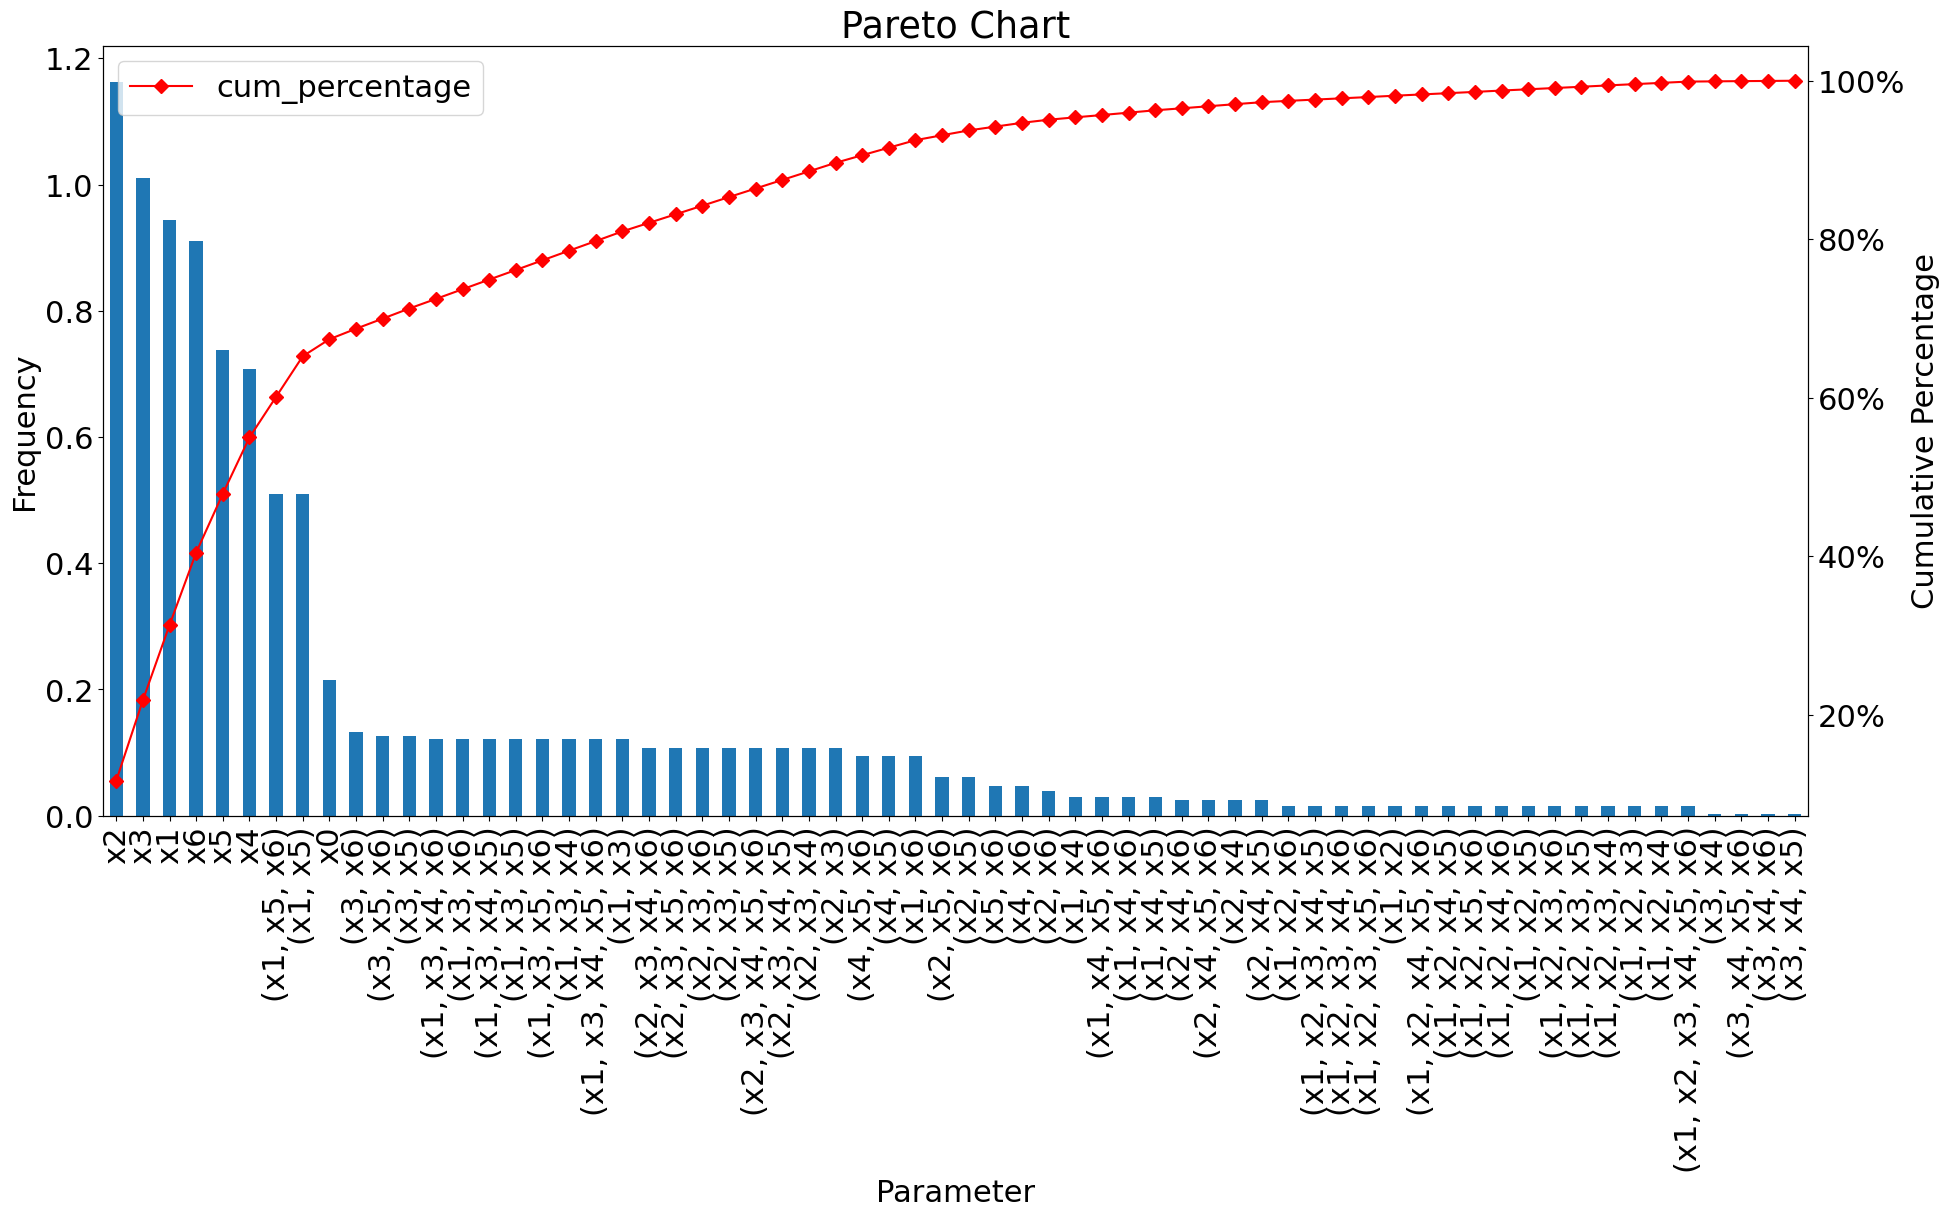

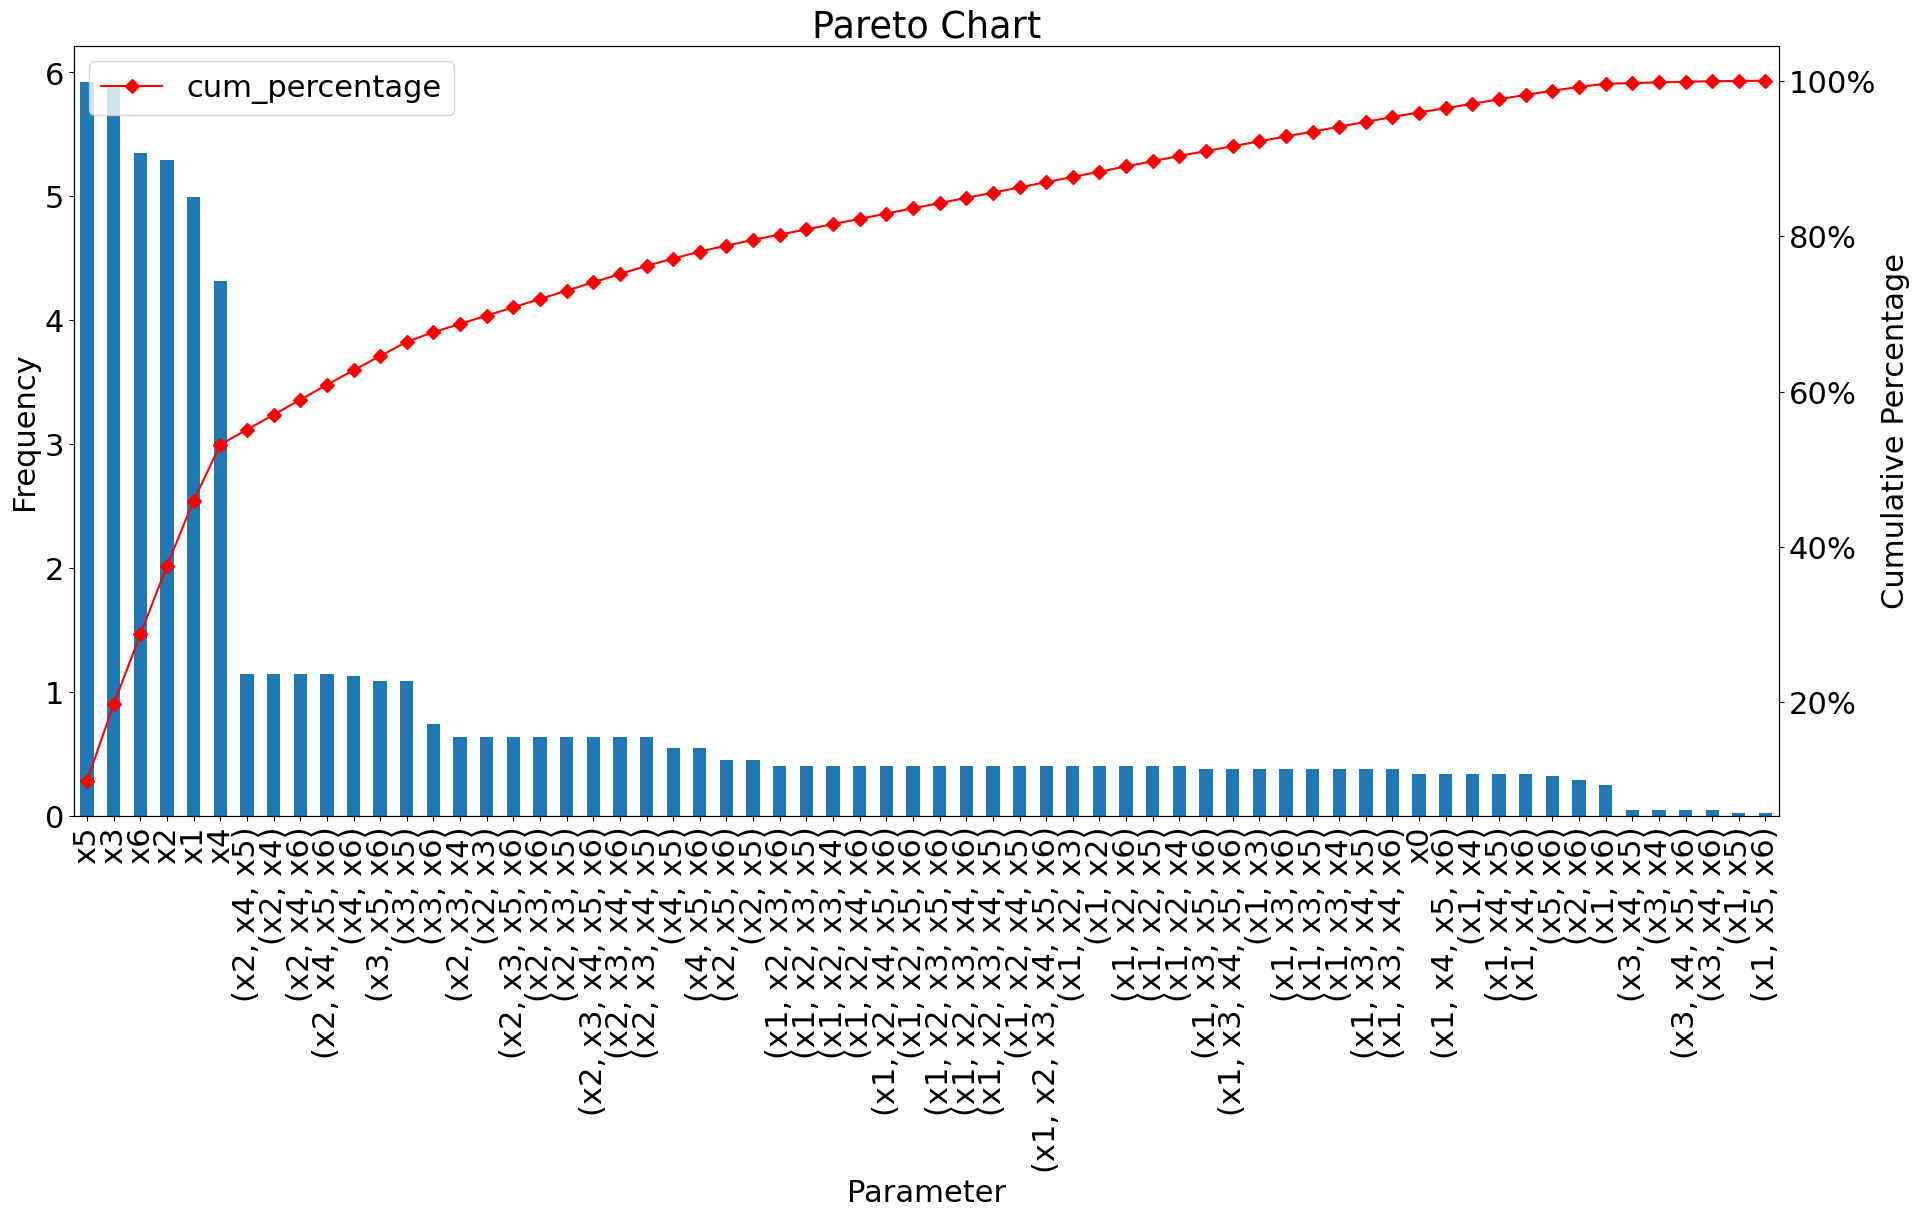

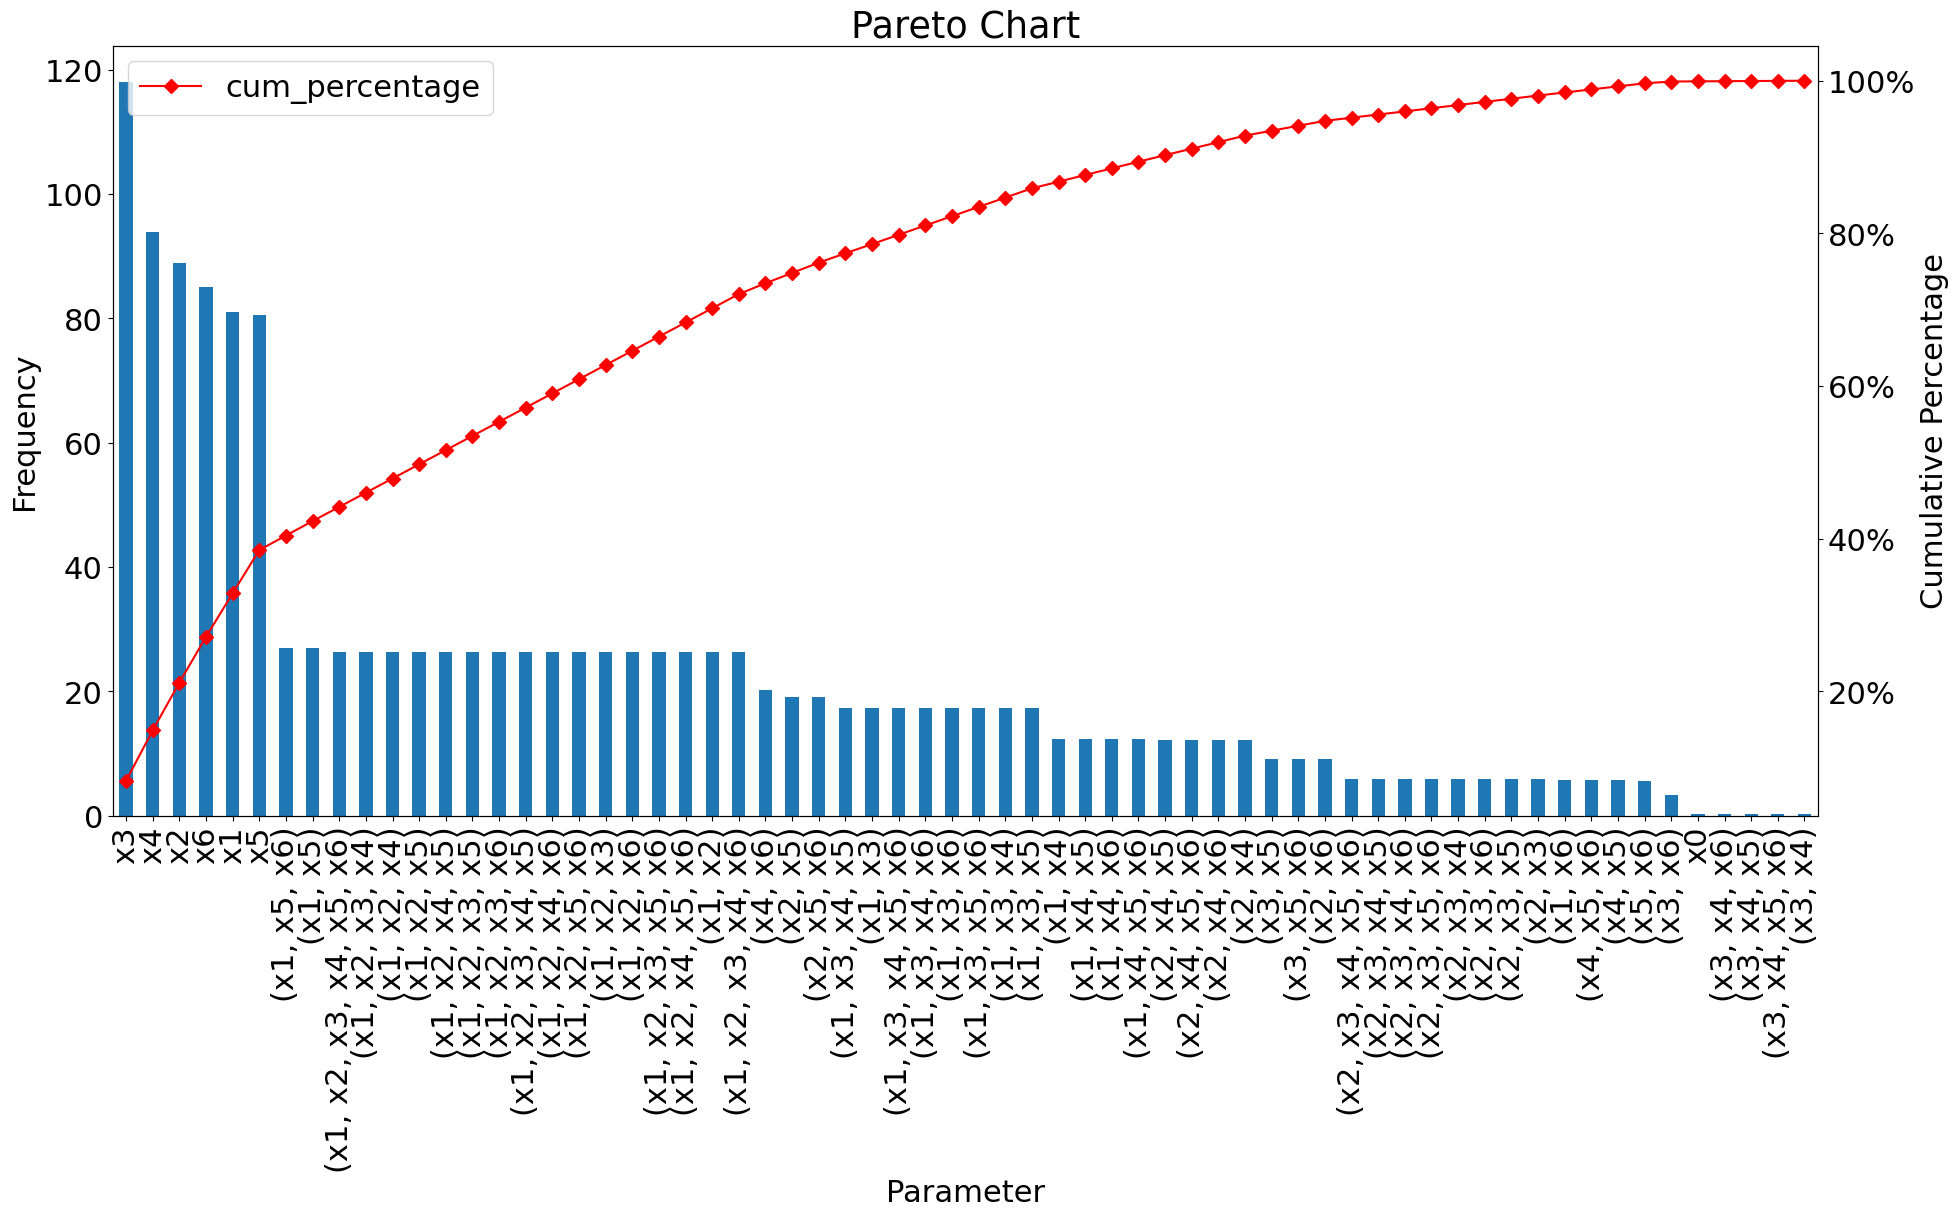

In [15]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
master_df
indexes=['y1', 'y2', 'y3']
for ii in indexes: 
    effects_df=pd.DataFrame(master_df[ii].abs())
    effects_df = effects_df.sort_values(by=ii, ascending=False)
# Add cumulative percentage column
    effects_df["cum_percentage"] = round(effects_df[ii].cumsum()/effects_df[ii].sum()*100,2)
    plt.rcParams.update({'font.size': 22})
# Set figure and axis
    fig, ax = plt.subplots(figsize=(22,10))

# Plot bars (i.e. frequencies)
    ax.set_title("Pareto Chart")
    ax.set_xlabel("Parameter")
    ax.set_ylabel("Frequency");
    effects_df[ii].plot.bar(y='Standardized effect', ax=ax)
#    ax.axhline(2.06, color="orange", linestyle="dashed")

# Second y axis (i.e. cumulative percentage)
    ax2 = ax.twinx()
#ax2.plot(effects_df.index, effects_df["cum_percentage"], color="red", marker="D", ms=7)
    effects_df.plot(y="cum_percentage", color="red", marker="D", ms=7, ax=ax2)
    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax2.set_ylabel("Cumulative Percentage");

However, looking at the quantile-quantile plot of the effects answers the question in a more visual way.

## Quantile-Quantile Effects Plot
We can examine the distribution of the various input variable effects using a quantile-quantile plot of the effects. Quantile-quantile plots arrange the effects in order from least to greatest, and can be applied in several contexts (as we'll see below, when assessing model fits). If the quantities plotted on a quantile-qantile plot are normally distributed, they will fall on a straight line; data that do not fall on the straight line indicate significant deviations from normal behavior.

In the case of a quantile-quantile plot of effects, non-normal behavior means the effect is paticularly strong. By identifying the outlier points on thse quantile-quantile plots (they're ranked in order, so they correspond to the lists printed above), we can identify the input variables most likely to have a strong impact on the responses.

We need to look both at the top (the variables that have the largest overall positive effect) and the bottom (the variables that have the largest overall negative effect) for significant outliers. When we find outliers, we can add them to a list of variabls that we have decided are important and will keep in our analysis.

Text(0.5, 1.0, 'y3')

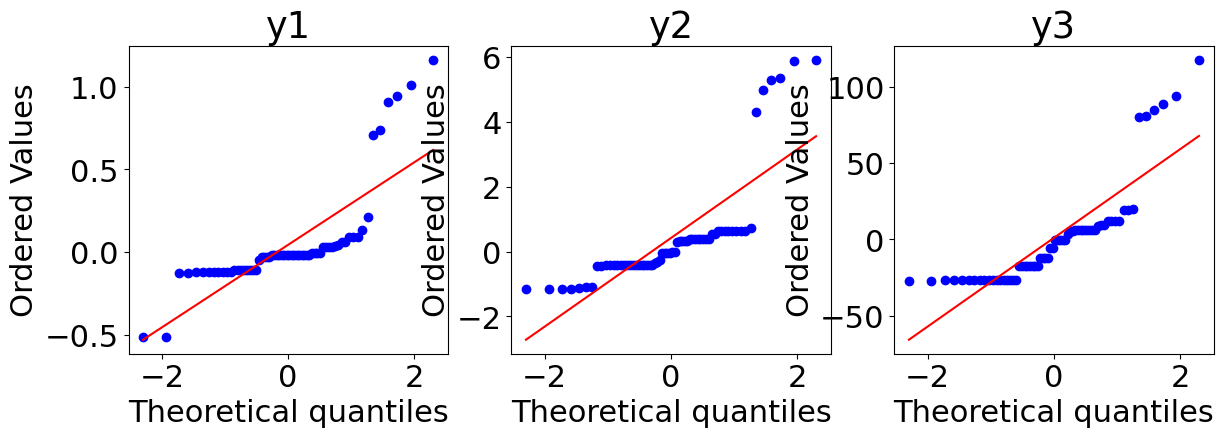

In [16]:
# Quantify which effects are not normally distributed, 
# to assist in identifying important variables

fig = figure(figsize=(14,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

stats.probplot(y1, dist="norm", plot=ax1)
ax1.set_title('y1')

stats.probplot(y2, dist="norm", plot=ax2)
ax2.set_title('y2')

stats.probplot(y3, dist="norm", plot=ax3)
ax3.set_title('y3')

Normally, we would use the main effects that were computed, and their rankings, to eliminate any variables that don't have a strong effect on any of our variables. However, this analysis shows that sometimes we can't eliminate any variables.

All six input variables are depicted as the effects that fall far from the red line - indicating all have a statistically meaningful (i.e., not normally distributed) effect on all three response variables. This means we should keep all six factors in our analysis.

There is also a point on the  y3
  graph that appears significant on the bottom. Examining the output of the lists above, this point represents the effect for the six-way interaction of all input variables. High-order interactions are highly unlikely (and in this case it is a numerical artifact of the way the responses were generated), so we'll keep things simple and stick to a linear model.